TODO: 
- investigate arm dropping logic
- read the WD paper

In [1]:
import imprint.nb_util as nb_util
nb_util.setup_nb()

import time
import jax
import jax.numpy as jnp
from jax.scipy.special import expit, logit
import numpy as np
import matplotlib.pyplot as plt

import confirm.models.wd41 as wd41
import imprint as ip

model = wd41.WD41(0, 500000)

We have two subgroups, each split equally into treatment and control arms:
- $p_{\mathrm{TNBC}}^{c}$ - TNBC subgroup control arm.
- $p_{\mathrm{TNBC}}^{t}$ - TNBC subgroup treatment arm.
- $p_{\mathrm{HR+}}^{c}$ - HR+ subgroup control arm.
- $p_{\mathrm{HR+}}^{t}$ - HR+ subgroup treatment arm.
  
$f_{\mathrm{TNBC}}$ is the fraction of patients in the TNBC subgroup.

The null hypotheses here are:

$$
p_{\mathrm{TNBC}}^{c} > p_{\mathrm{TNBC}}^{t}
$$

$$
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{c} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{c} > 
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{t} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{t}
$$

In [2]:
grid = ip.cartesian_grid(
    [-1, -2.5, -1, -2.5],
    [-1, -0.0, -1, -0.0],
    n=[1, 90, 1, 90],
    null_hypos = model.null_hypos
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=8100, worker_id=1, t=1677184767, n_bits=18, worker_bits=18) = [4574795135573032960 4574795135573032961 4574795135573032962, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=338, worker_id=1, t=1677184768, n_bits=18, worker_bits=18) = [4574795204292509696 4574795204292509697 4574795204292509698, ...]:


In [5]:
val_df = ip.validate(wd41.WD41, g=grid, lam=0.025, K=10000)

In [6]:
theta = grid.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p[0, 0] * f + p[0, 2] * (1 - f)) - (ptt * f)) / (1 - f)

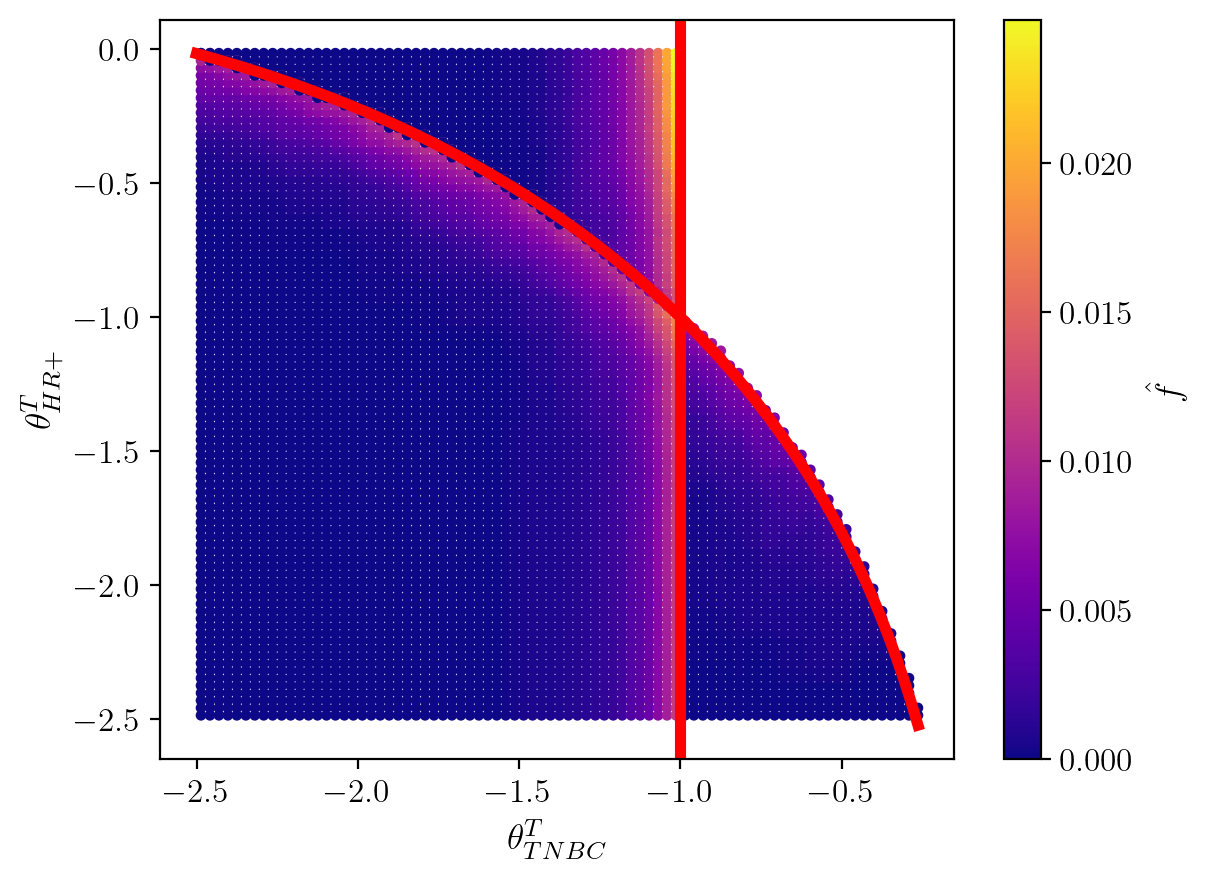

In [23]:
plt.scatter(theta[:,1], theta[:,3], c=val_df['tie_est'], s=8)
plt.axvline(logit(p[0, 0]), color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\hat{f}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.show()

In [25]:
jax.scipy.stats.norm.cdf(-3.0)

DeviceArray(0.0013499, dtype=float32)

In [3]:
out = model.sim_batch(0, 500000, jnp.array([[0.34, 0.44, 0.23, 0.33]]), jnp.array([[True, True]]))

In [4]:
np.sum(out < 0.025) / out.shape[1]

DeviceArray(0.044464, dtype=float32)

In [10]:
cal_df = ip.calibrate(wd41.WD41, g=grid, alpha=0.025, K=10000)

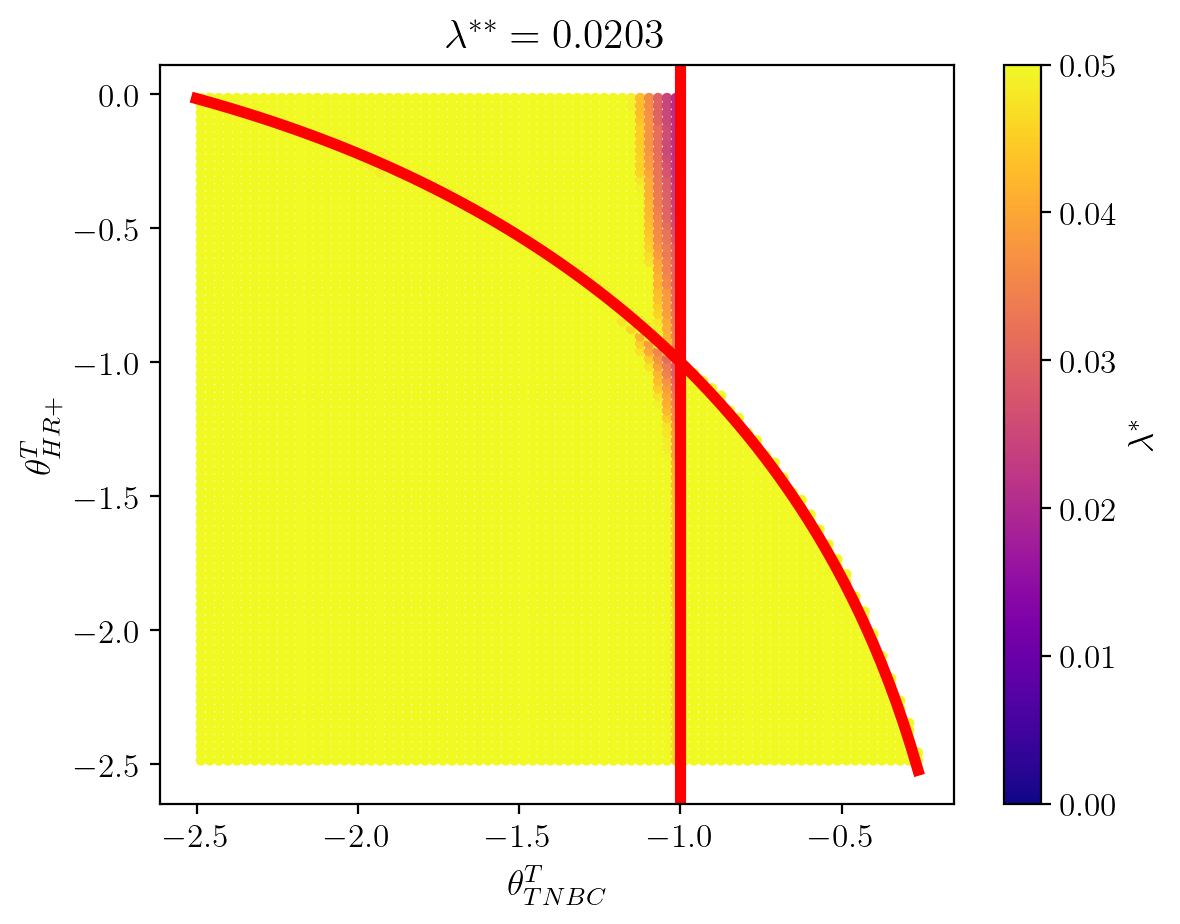

In [26]:
plt.scatter(theta[:,1], theta[:,3], c=cal_df['lams'], s=8, vmin=0, vmax=0.05)
plt.axvline(logit(p[0, 0]), color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.title('$\lambda^{**}='+f'{cal_df["lams"].min():.4f}$')
plt.show()

In [12]:
cal_df['lams'].min()

0.020342464